# Load libraries & helper functions

In [ ]:
from helpers_clean import *
%matplotlib inline

In [108]:
from matplotlib import cm
import scipy.stats as stats
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
from sklearn import linear_model
%matplotlib inline

# Declare parameters

In [212]:
resultsDir = 'D:\\test'
behavFile = 'unrestricted_paolagaldi_8_10_2017_16_20_31.csv'
RbehavFile = 'RESTRICTED_paolagaldi_8_10_2017_16_31_0.csv'
parcellations = ['shen2013','Glasser'];
scores        = ['PMAT24_A_CR','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']
confounds     = ['Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum_REST1','FDsum_REST2','fMRI_3T_ReconVrs','PMAT24_A_CR']
release       = 'Q2';
sessions      = ['REST1','REST2']
preprocs      = ['A','B','C']
predAlgs      = ['Finn'];#'elnet',
thr           = 0.01;

## Figure 2: Plot Behavior

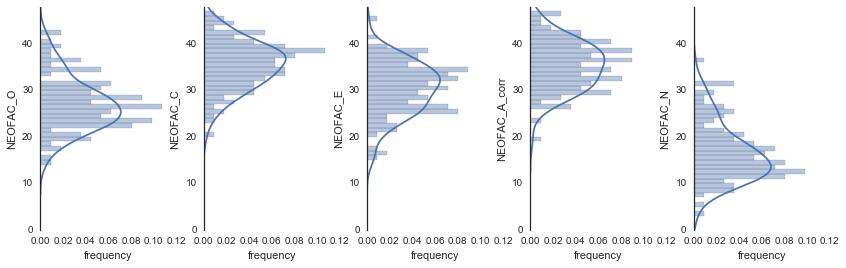

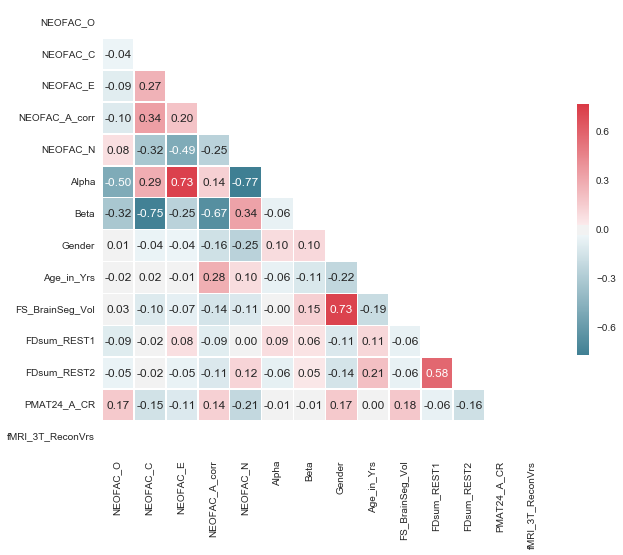

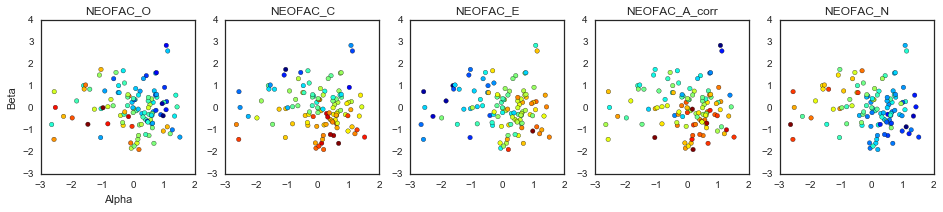

In [176]:
df = pd.read_csv(op.join(resultsDir,'df.csv'))

scoreL  = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N', 'Alpha', 'Beta']
scoreMat = None
for score in scoreL:
    # add to conMat
    if scoreMat is None:
        scoreMat = np.ravel(df[score])
    else:
        scoreMat = np.vstack((scoreMat,np.ravel(df[score])))

# SHOW DISTRIBUTIONS
fig = plt.figure(figsize=(20,4))
for iScore,score in enumerate(scoreL[:5]):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    sns.distplot(scoreMat[iScore,:],bins=range(49), vertical=True)
    ax.set(ylim=(0, 48), xlim=(0, .12), ylabel=score,xlabel="frequency")
    sns.despine(left=False, bottom=True)

    
for i1,score1 in enumerate(scoreL):
    for i2,score2 in enumerate(scoreL):
        if i2>i1:
            tmpCorr = stats.pearsonr(np.ravel(df[score1]),np.ravel(df[score2]))
SML    = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N', 'Alpha', 'Beta',
          'Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum_REST1','FDsum_REST2','PMAT24_A_CR','fMRI_3T_ReconVrs']
thisdf = df[SML].copy()
corr = thisdf.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

alpha = df['Alpha']
beta = df['Beta']
sizes = 20*np.ones(alpha.shape[0])
fig = plt.figure(figsize=(16,4));
reorder = np.argsort(sizes)
for iScore,score in enumerate(scoreL[:5]):
    ax = fig.add_subplot(1,len(scoreL[:5]),iScore+1)
    plt.scatter(alpha[reorder],beta[reorder],s=sizes[reorder],c=np.ravel(df[score][reorder]),cmap=plt.cm.jet)
    ax.set_aspect(1./ax.get_data_ratio())
    plt.title(score)
    if iScore==0:
        plt.xlabel('Alpha')
        plt.ylabel('Beta')

## Figure 3: Compare FC mats

In [102]:
np.array(df[confounds]).shape

(112, 7)

In [101]:
conMat = None
for confound in confounds:
    if conMat is None:
        conMat = np.array(np.ravel(df[confound]))
    else:
        conMat = np.vstack((conMat,df[confound]))
conMat = conMat.T
conMat.shape

(112, 7)

In [134]:
fcMatCorr.shape[0]

2

In [136]:
np.matrix([[stats.pearsonr(fcMatCorr[i,:],fcMatCorr[j,:])[0] for i in range(fcMatCorr.shape[0])] for j in range(fcMatCorr.shape[0])]) 

matrix([[ 1.,  1.],
        [ 1.,  1.]])

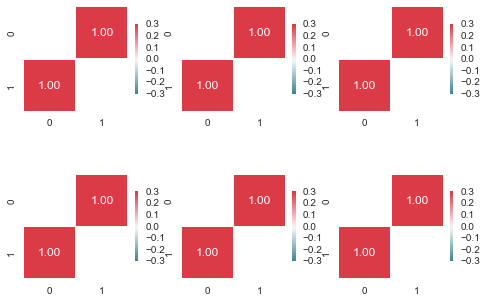

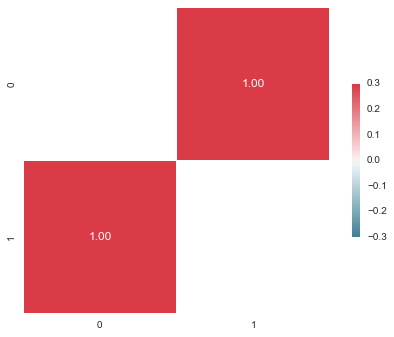

In [199]:
parcellations = ['shen2013','Glasser']
scores        = ['PMAT24_A_CR','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']
confounds     = ['Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum_REST1','FDsum_REST2','fMRI_3T_ReconVrs','PMAT24_A_CR']
release       = 'all+MEG2';
sessions      = ['REST1','REST2']
preprocs      = ['A','B','C']

parcellations = ['shen2013']
scores        = ['PMAT24_A_CR','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']
confounds     = ['Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum_REST1','FDsum_REST2','fMRI_3T_ReconVrs','PMAT24_A_CR']
release       = 'Q2';
sessions      = ['REST1','REST2']
preprocs      = ['A']

#csvFile = op.join(inDir, 'df.csv')
csvFile = op.join(resultsDir, 'df.csv')
df = pd.read_csv(csvFile)
nSubjects = len(df)

behavUtil = {}
pairwiseSim = {}
fcMatsAll = {}
for parcellation in parcellations:
    if parcellation == 'shen2013':
        nNodes = 268
    elif parcellation == 'Glasser':
        nNodes = 360
    nEdges = int(nNodes * (nNodes-1) / 2)
    for iPrep in range(len(preprocs)):
        preproc = preprocs[iPrep]
        inDir = op.join(resultsDir,preproc,parcellation)
        #fcMatFile = op.join(inDir, 'fcMats.mat')
        fcMatFile = op.join(resultsDir, 'fcMats.mat')
        if op.isfile(fcMatFile):
            fcMats = sio.loadmat(fcMatFile)
            for session in sessions:
                tmp = np.zeros([nSubjects,nEdges])
                for iSub in range(nSubjects):
                    fcMat = fcMats['fcMats_{}'.format(session)][:,:,iSub]
                    tmp[iSub,:] = fcMat[np.triu_indices(nNodes,k=1)]
                fcMatsAll[','.join([session,preproc])] = tmp
        else:
            continue
            
    # RELATIONSHIP OF EACH EDGE WITH BEHAVIOR
    for score in scores:
        if score == 'PMAT24_A_CR':
            decon = 'decon'
        else:
            decon = 'decon+IQ'
        fcMatCorr = np.zeros((len(sessions)*len(preprocs),nEdges))
        for iSess in range(len(sessions)):
            session = sessions[iSession]
            if decon=='decon':
                conMat = np.array(df[['Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum_{}'.format(session),'fMRI_3T_ReconVrs']])
            elif decon=='decon+IQ':
                conMat = np.array(df[['Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum_{}'.format(session),'fMRI_3T_ReconVrs','PMAT24_A_CR']]) 
            regr = linear_model.LinearRegression()
            regr.fit(conMat, df[score])
            fittedvalues = regr.predict(conMat)
            resid = df[score] - np.ravel(fittedvalues)
            for iPrep in range(len(preprocs)):
                for i in range(nEdges):
                    fcMatCorr[iSess*len(preprocs)+iPrep,i] = stats.pearsonr(resid,fcMatsAll[','.join([session,preproc])][:,i])[0]
        behavUtil[','.join([parcellation,score])] = np.array([[stats.pearsonr(fcMatCorr[i,:],fcMatCorr[j,:])[0] for i in range(fcMatCorr.shape[0])] 
                                                               for j in range(fcMatCorr.shape[0])]) 
    
    # SIMILARITY BETWEEN SUBJECTS
    fcMatSim = np.zeros([len(sessions)*len(preprocs), int(nSubjects*(nSubjects-1)/2)])
    for iSess in range(len(sessions)):
        session = sessions[iSession]
        for iPrep in range(len(preprocs)):
            preproc = preprocs[iPrep]
            if ','.join([session,preproc]) in fcMatsAll:
                fcMat = fcMatsAll[','.join([session,preproc])]
                tmp = np.array([[stats.pearsonr(fcMat[i,:],fcMat[j,:])[0] for i in range(fcMat.shape[0])] 
                                                               for j in range(fcMat.shape[0])])
                fcMatSim[iSess*len(preprocs)+iPrep,:] = tmp[np.triu_indices(nSubjects,k=1)]
    pairwiseSim[parcellation] = np.array([[stats.pearsonr(fcMatSim[i,:],fcMatSim[j,:])[0] for i in range(fcMatSim.shape[0])] 
                                                               for j in range(fcMatSim.shape[0])]) 
    
    # IDENTIFIABILITY (FINGERPRINTING)
    allMatch = np.zeros([6,len(preprocs)])
    direction = 1
    for iPrep in range(len(preprocs)):
        if direction == 1: # Fingerprinting 1 > 2
            match = np.zeros([nSubjects,5])
            for sub1 in range(nSubjects):
                tmp = np.array([stats.pearsonr(fcMatsAll[','.join(['REST1',preproc])][sub1,:],fcMatsAll[','.join(['REST2',preproc])][j,:])[0] 
                                 for j in range(fcMatsAll[','.join(['REST1',preproc])].shape[0])])
                maxi,indmaxi = np.max(tmp), np.argmax(tmp)
                match[sub1,0]  = (indmaxi==sub1)
                match[sub1,1]  = maxi
                match[sub1,2]  = tmp[sub1]
                match[sub1,3]  = np.mean(tmp[np.setdiff1d(np.arange(nSubjects),sub1)])
                match[sub1,4]  = np.max(tmp[np.setdiff1d(np.arange(nSubjects),sub1)])
        elif direction == 2: # Fingerprinting 1 > 2
            match = np.zeros([nSubjects,5])
            for sub1 in range(nSubjects):
                tmp = np.array([stats.pearsonr(fcMatsAll[','.join(['REST2',preproc])][sub2,:],fcMatsAll[','.join(['REST1',preproc])][j,:])[0] 
                                 for j in range(fcMatsAll[','.join(['REST2',preproc])].shape[0])])
                maxi,indmaxi = np.max(tmp), np.argmax(tmp)
                match[sub2,0]  = (indmaxi==sub1)
                match[sub2,1]  = maxi
                match[sub2,2]  = tmp[sub1]
                match[sub2,3]  = np.mean(tmp[np.setdiff1d(np.arange(nSubjects),sub1)])
                match[sub2,4]  = np.max(tmp[np.setdiff1d(np.arange(nSubjects),sub1)])
        allMatch[0,iPrep] = np.sum(match[:,0])/match.shape[0]
        allMatch[1,iPrep] = np.mean(match[np.where(match[:,1]>0),1])
        allMatch[2,iPrep] = np.mean(match[:,2])
        allMatch[3,iPrep] = np.mean(match[:,3])
        allMatch[4,iPrep] = np.min(match[:,2])
        allMatch[5,iPrep] = np.max(match[:,4])
            
for iScore in range(len(scores)):
    score = scores[iScore]
    plt.subplot(2,len(scores)/2,iScore+1)
    tmp = np.zeros([len(preprocs)*len(sessions),len(preprocs)*len(sessions)])
    tmp[np.triu_indices_from(tmp,k=1)] = behavUtil[','.join([parcellations[0],score])][np.triu_indices_from(tmp,k=1)]
    tmp[np.tril_indices_from(tmp,k=-1)] = behavUtil[','.join([parcellations[1],score])][np.tril_indices_from(tmp,k=-1)]
    mask = np.zeros_like(tmp, dtype=np.bool)
    mask[np.diag_indices_from(mask)] = True
    sns.heatmap(tmp, annot=True, fmt=".2f", mask=mask,cmap=cmap, vmax=.3, center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
plt.figure()
tmp = np.zeros([len(preprocs)*len(sessions),len(preprocs)*len(sessions)])
tmp[np.triu_indices_from(tmp,k=1)] = pairwiseSim[parcellations[0]][np.triu_indices_from(tmp,k=1)]
tmp[np.tril_indices_from(tmp,k=-1)] = pairwiseSim[parcellations[1]][np.tril_indices_from(tmp,k=-1)]  
mask = np.zeros_like(tmp, dtype=np.bool)
mask[np.diag_indices_from(mask)] = True
sns.heatmap(tmp, annot=True, fmt=".2f", mask=mask,cmap=cmap, vmax=.3, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


## Figures 4 & 5: Plot Performance

KeyError: 'PMAT24_A_CR,shen2013,B,Finn,REST2'

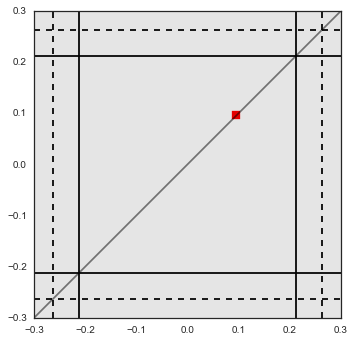

In [224]:
styles = ['-','--',':','-','--',':']
r = np.linspace(-1, 1, 2000)
t = r * np.sqrt((nSubjects-2)/(1-r**2))
p2 = 2 * (1-stats.t.cdf(np.abs(t),nSubjects-2))
th05 = [r[np.where(p2>=0.025)[0][0]],r[np.where(p2>=0.025)[0][-1]]]
th01 = [r[np.where(p2>=0.005)[0][0]],r[np.where(p2>=0.005)[0][-1]]]
th001 = [r[np.where(p2>=0.0005)[0][0]],r[np.where(p2>=0.0005)[0][-1]]]
thThr = np.vstack((th05, th01, th001))
rhos = {}

for parcellation in parcellations:
    if parcellation == 'shen2013':
        nNodes        = 268
    elif parcellation == 'Glasser':
        nNodes     = 360

    nEdges = nNodes * (nNodes-1) / 2
    for predAlg in predAlgs:
        for preproc in preprocs:
            #inDir = op.join(ROOTDIR,'data','HCP','MRI','Results','FINAL',preproc,parcellation)
            inDir = resultsDir
            for SM in SMs:
                for session in sessions:
                    if SM == 'PMAT24_A_CR':
                        decon = 'decon'
                    else:
                        decon = 'decon+IQ'
                    inDir_ = op.join(inDir,'{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                            SM,preproc,parcellation,session,decon,predAlg,release,thr),'0000')
                    try:
                        if predAlg == 'Finn':
                            res0 = sio.loadmat(op.join(inDir_,'result.mat')) 
                            rhos[','.join([SM,parcellation,preproc,predAlg,session])] = res0['rho_pos']
                            nSub = len(res0['pred_pos'])
                        else:
                            res0 = sio.loadmat(op.join(inDir_,'result.mat')) 
                            rhos[','.join([SM,parcellation,preproc,predAlg,session])] = res0['rho']
                            nSub = len(res0['pred_pos'])
                    except:
                        pass

for iSM in range(len(SMs)):
    SM = SMs[iSM]
    plt.subplot(2,len(SMs)/2,iSM+1)
    plt.title(SM)
    lim = .3
    plt.axes().set_aspect('equal')
    ax = plt.gca()
    ax.set_xlim(lim*np.array([-1,1]))
    ax.set_ylim(lim*np.array([-1,1]))
    # theoretical thresholds
    ax.fill([thThr[2,0], thThr[2,1], thThr[2,1], thThr[2,0]],[thThr[2,0], thThr[2,0], thThr[2,1], thThr[2,1]],'k',alpha=0.1)
    istyle = 0
    for el in np.ravel(thThr,order='F'):
        line = plt.Line2D([-lim,lim],[el,el], c='k',linestyle=styles[istyle])
        ax.add_line(line)
        istyle=istyle+1
    istyle=0    
    for el in np.ravel(thThr, order='F'):
        line = plt.Line2D([el,el],[-lim,lim], c='k',linestyle=styles[istyle])
        ax.add_line(line)    
        istyle=istyle+1
    # diagonal
    line = plt.Line2D([-lim,lim],[-lim,lim], c='k', linestyle='-',alpha=.5)
    ax.add_line(line)
    # show data
    inLegend = []
    legendEntries = []
    colors = cm.get_cmap('hsv',2)
    symbols  = ['s','^','v']
    for iParcel in range(len(parcellations)):
        parcellation = parcellations[iParcel]
        for iPrep in range(len(preprocs)):
            preproc = preprocs[iPrep]
            for predAlg in predAlgs:
                if predAlg == 'Finn':
                    h = plt.scatter(rhos[','.join([SM,parcellation,preproc,predAlg,sessions[0]])],rhos[','.join([SM,parcellation,preproc,predAlg,sessions[1]])],75,colors(iParcel),symbols[iPrep],edgecolors='face')  
                elif predAlg == 'elnet':
                    h = plt.scatter(rhos[','.join([SM,parcellation,preproc,predAlg,sessions[0]])],rhos[','.join([SM,parcellation,preproc,predAlg,sessions[1]])],75,colors(iParcel),symbols[iPrep],facecolors='none', edgecolors=mycm(iParcel))
                inLegend.append(h)
                legendEntries.append('{}/{}/{}'.format(parcellation,preproc,predAlg))
    if iSM == 0:
        plt.legend(inLegend, legendEntries, loc=4)
    plt.xlabel('correlation predicted vs. measured, REST1')
    plt.ylabel('correlation predicted vs. measured, REST2')

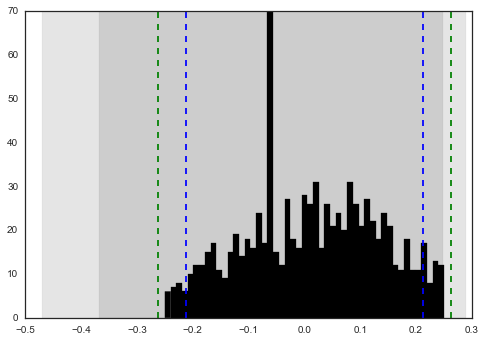

In [233]:
inDir = op.join(resultsDir,'PMAT24_A_CR_A_shen2013_REST2_decon_Finn_Q2_thr0.01')
nPerm = 1000 
rho = np.zeros(2)
rhoPerm = np.empty([nPerm+1,2])
rhoPerm[:] = np.nan

for iPerm in range(nPerm+1):
    try:
        res = sio.loadmat(op.join(inDir,'{:04d}'.format(iPerm),'result.mat'))
    except:
        pass
    if iPerm == 0:
        rho[0] = res['rho_pos']
        rho[1] = res['rho_neg']
    else: 
        rhoPerm[iPerm,0] = res['rho_pos']
        rhoPerm[iPerm,1] = res['rho_neg']
rhoPerm = rhoPerm[np.logical_not(np.isnan(np.sum(rhoPerm,axis=1))),:]

# theoretical threshold
res = sio.loadmat(op.join(inDir, '0000', 'result.mat'))
pred_pos = res['pred_pos']

r = np.linspace(-1, 1, 2000)
t = r * np.sqrt((nSub-2)/(1-r**2))
p2 = 2 * (1-stats.t.cdf(np.abs(t),nSub-2))
th05 = [r[np.where(p2>=0.025)[0][0]],r[np.where(p2>=0.025)[0][-1]]]
th01 = [r[np.where(p2>=0.005)[0][0]],r[np.where(p2>=0.005)[0][-1]]]
thThr = np.vstack((th05, th01, th001))

xs = np.linspace(-.25,.25,50)
i=0 # rho_pos 0, rho_neg 1
empThr05 = [np.percentile(rhoPerm[:,i],[2.5, 97.5],interpolation='midpoint')]
empThr01 = [np.percentile(rhoPerm[:,i],[.5, 99.5],interpolation='midpoint')]
empThr = np.vstack((empThr05, empThr01))
Ns, bins = np.histogram(rhoPerm[:,i], xs)
plt.hist(rhoPerm[:,i], bins,color='k')
ax = plt.gca()
v = ax.get_ylim()
ax.fill(np.hstack([empThr[1,:], empThr[1,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
ax.fill(np.hstack([empThr[0,:], empThr[0,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
# 95% theoretical threshold
line = plt.Line2D([thThr[0,0],thThr[0,0]],[v[0],v[1]], c='b', linestyle='--')
ax.add_line(line)
line = plt.Line2D([thThr[0,-1],thThr[0,-1]],[v[0],v[1]], c='b', linestyle='--')
ax.add_line(line)
# 99% theoretical threshold
line = plt.Line2D([thThr[1,0],thThr[1,0]],[v[0],v[1]], c='g', linestyle='--')
ax.add_line(line)
line = plt.Line2D([thThr[1,-1],thThr[1,-1]],[v[0],v[1]], c='g', linestyle='--')
ax.add_line(line)

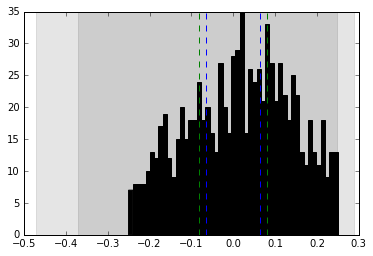

In [165]:
rhoPerm = np.loadtxt('rhoPerms.txt')

# theoretical threshold
res = sio.loadmat('result.mat')
pred_pos = res['pred_pos']

r = np.linspace(-1, 1, 2000)
t = r * np.sqrt((nSub-2)/(1-r**2))
p2 = 2 * (1-stats.t.cdf(np.abs(t),nSub-2))
th05 = [r[np.where(p2>=0.025)[0][0]],r[np.where(p2>=0.025)[0][-1]]]
th01 = [r[np.where(p2>=0.005)[0][0]],r[np.where(p2>=0.005)[0][-1]]]
thThr = np.vstack((th05, th01, th001))

xs = np.linspace(-.25,.25,50)
i=0 # rho_pos 0, rho_neg 1
empThr05 = [np.percentile(rhoPerm[:,i],[2.5, 97.5],interpolation='midpoint')]
empThr01 = [np.percentile(rhoPerm[:,i],[.5, 99.5],interpolation='midpoint')]
empThr = np.vstack((empThr05, empThr01))
Ns, bins = np.histogram(rhoPerm[:,i], xs)
plt.hist(rhoPerm[:,i], bins,color='k')
ax = plt.gca()
v = ax.get_ylim()
ax.fill(np.hstack([empThr[1,:], empThr[1,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
ax.fill(np.hstack([empThr[0,:], empThr[0,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
# 95% theoretical threshold
line = plt.Line2D([thThr[0,0],thThr[0,0]],[v[0],v[1]], c='b', linestyle='--')
ax.add_line(line)
line = plt.Line2D([thThr[0,-1],thThr[0,-1]],[v[0],v[1]], c='b', linestyle='--')
ax.add_line(line)
# 99% theoretical threshold
line = plt.Line2D([thThr[1,0],thThr[1,0]],[v[0],v[1]], c='g', linestyle='--')
ax.add_line(line)
line = plt.Line2D([thThr[1,-1],thThr[1,-1]],[v[0],v[1]], c='g', linestyle='--')
ax.add_line(line)